In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import warnings
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import BertModel, BertTokenizer
from sentence_transformers import SentenceTransformer

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
from torch.optim.lr_scheduler import StepLR

nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

print(nltk.data.find('tokenizers/punkt'))

C:\Users\77771\AppData\Roaming\nltk_data\tokenizers\punkt


In [2]:
!kaggle datasets download -d julian3833/jigsaw-toxic-comment-classification-challenge -q

Dataset URL: https://www.kaggle.com/datasets/julian3833/jigsaw-toxic-comment-classification-challenge
License(s): CC0-1.0


In [3]:
import zipfile
import os

dir_path = '/Users/77771/Desktop/Projects/ToxicityClassifier'
zip_file = f'{dir_path}/jigsaw-toxic-comment-classification-challenge.zip'

# Распаковка архива
with zipfile.ZipFile(zip_file, 'r') as zips:
    zips.extractall(dir_path)

# Вывод содержимого распакованной папки
os.listdir(dir_path)


['.git',
 '.ipynb_checkpoints',
 'Classifier.ipynb',
 'jigsaw-toxic-comment-classification-challenge.zip',
 'README.md',
 'sample_submission.csv',
 'test.csv',
 'test_labels.csv',
 'train.csv']

In [4]:
train_data = pd.read_csv(f'{dir_path}/train.csv').drop('id', axis=1)
train_data.shape

(159571, 7)

In [5]:
train_data.head(5)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
labels_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [7]:
train_data.head(5)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


удаление данных без меток

In [8]:
train_data = train_data[(train_data[labels_columns]).sum(axis=1)!=0]
train_data.shape

(16225, 7)

In [9]:
labels_count = train_data[labels_columns].sum()
all_comments = len(train_data)
label_perc = labels_count / all_comments * 100

# for label in labels_columns:
#     print(f'Метка: "{label}" \nКоличество комментариев: {labels_count[label]} \nПроцент от общего числа комментариев: {label_perc[label]:.2f}%')
#     print('--------------------------------------------')

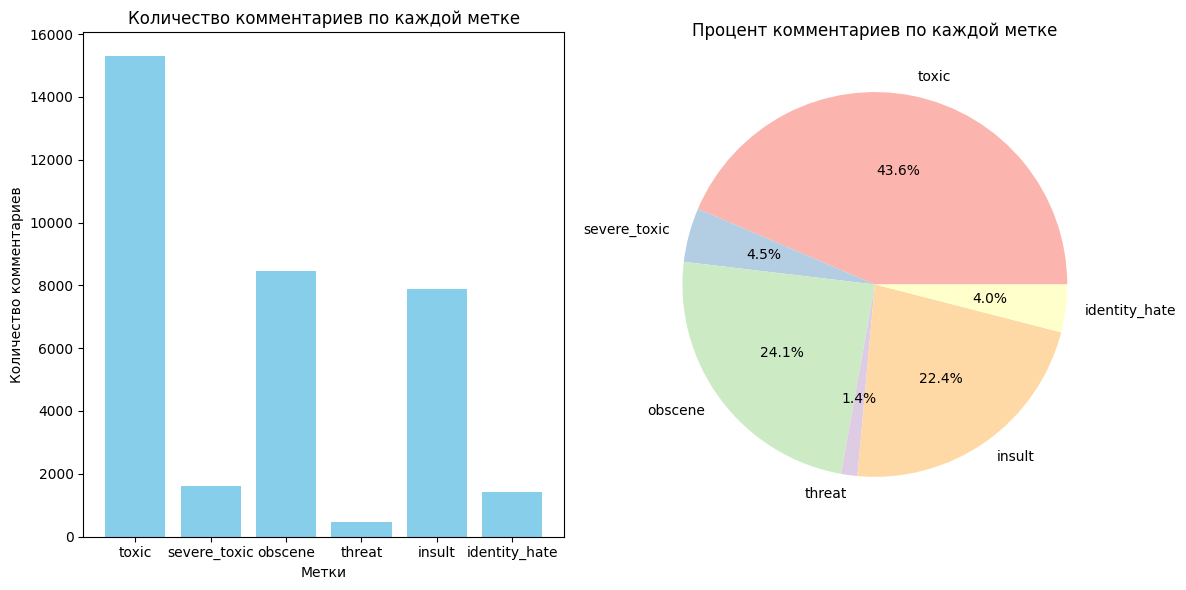

In [10]:
# Создаем два подграфика (1 строка, 2 столбца)
plt.figure(figsize=(12, 6))

# Столбчатая диаграмма для количества комментариев
plt.subplot(1, 2, 1)  # 1 строка, 2 столбца, 1-й график
plt.bar(labels_columns, labels_count, color='skyblue')
plt.title('Количество комментариев по каждой метке')
plt.xlabel('Метки')
plt.ylabel('Количество комментариев')

# Круговая диаграмма для процентов
plt.subplot(1, 2, 2)  # 1 строка, 2 столбца, 2-й график
plt.pie(label_perc, labels=labels_columns, autopct='%1.1f%%', colors=plt.cm.Pastel1.colors)
plt.title('Процент комментариев по каждой метке')

# Отображаем оба графика
plt.tight_layout() 
plt.show()

In [11]:
train_data.head(10)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
44,I'm Sorry \n\nI'm sorry I screwed around with ...,1,0,0,0,0,0
51,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0
55,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0
56,=Tony Sidaway is obviously a fistfuckee. He lo...,1,0,1,0,1,0
58,My Band Page's deletion. You thought I was gon...,1,0,1,0,0,0


надо подумать про несколько меток, уменьшить количество данных

In [12]:

def text_cleaner(text):
    # Преобразование текста в нижний регистр
    text = text.lower()

    text = re.sub(r'[^a-z\s]', '', text) # удаление символов, которые не являются буквами

    # Удаление слов длиной 1 или 2 буквы
    text = re.sub(r'\b\w{1,2}\b', '', text)

    text = text.replace('\n', ' ')  # Заменяем символы новой строки на пробелы
    text = re.sub(r'\s+', ' ', text).strip() # удаляем лишние пробелы

    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    text = [word for word in tokens if word not in stop_words]

    # Лемматизация слов
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in text]

    # # Объединение лемматизированных слов обратно в текст
    text = ' '.join(lemmatized_text)

    return text


In [18]:
train_data['clean_comments'] = train_data['comment_text'].map(lambda comment: text_cleaner(comment))

In [15]:
# Загрузка предварительно обученной модели BERT
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [16]:
model = SentenceTransformer(model_name)

No sentence-transformers model found with name bert-base-uncased. Creating a new one with mean pooling.


In [25]:
cut_model = train_data.head(100)
embeddings = model.encode(cut_model['clean_comments'].tolist())

In [26]:
embeddings.shape

(100, 768)

In [27]:
y = cut_model[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=42)

In [29]:
# Преобразование данных в тензоры PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Создание DataLoader для обучающего и тестового наборов данных
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)